In [1]:
import squidpy as sq
import scanpy as sc
import scipy as scp
import numpy as np 
import pandas as pd
import scvi
import seaborn as sns
import pyensembl as ensb

In [2]:
sclcCells = sc.read_h5ad('hlca/sclcSinglets.h5ad')
normalCells = sc.read_h5ad('hlca/normalCells.h5ad')
sclcCells

AnnData object with n_obs × n_vars = 20561 × 56295
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 't

In [3]:
sclcCells.var['mitochondrial'] = sclcCells.var.feature_name.str.startswith('MT-')

In [4]:
ribosomalGeneSet = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt" # filter out ribosomal genes too
df_ribo = pd.read_table(ribosomalGeneSet, skiprows=2, header = None)
sclcCells.var[sclcCells.var.feature_name.isin(df_ribo[0].values)] # # two ribosomal genes
sclcCells.var['ribosomal'] = sclcCells.var.feature_name.isin(df_ribo[0].values) # bool for ribosomal genes

In [5]:
# Calculating QC metrics
sc.pp.calculate_qc_metrics(sclcCells, qc_vars=['mitochondrial', 'ribosomal'], percent_top=None, log1p=False, inplace=True)
sclcCells

AnnData object with n_obs × n_vars = 20561 × 56295
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 't

In [6]:
sclcCells.obs.n_genes_by_counts.min()

186

In [7]:
sc.pp.filter_genes(sclcCells, min_cells=3)
sc.pp.filter_cells(sclcCells, min_genes=200)
sclcCells

AnnData object with n_obs × n_vars = 20507 × 21184
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 't

In [8]:
sclcCells.var

feature_is_filtered original_gene_symbols feature_name  \
ensembl_id                                                                
ENSG00000121410                False                  A1BG         A1BG   
ENSG00000268895                False              A1BG-AS1     A1BG-AS1   
ENSG00000175899                False                   A2M          A2M   
ENSG00000245105                False               A2M-AS1      A2M-AS1   
ENSG00000166535                False                 A2ML1        A2ML1   
...                              ...                   ...          ...   
ENSG00000174903                False                 RAB1B        RAB1B   
ENSG00000159167                False                  STC1         STC1   
ENSG00000136854                False                STXBP1       STXBP1   
ENSG00000135605                False                   TEC          TEC   
ENSG00000109501                False                  WFS1         WFS1   

                feature_reference feature_biotype feature_length  \
ensembl_id                                                         
ENSG00000121410    NCBITaxon:9606            gene           3999   
ENSG00000268895    NCBITaxon:9606            gene           3374   
ENSG00000175899    NCBITaxon:9606            gene           6318   
ENSG00000245105    NCBITaxon:9606            gene           2948   
ENSG00000166535    NCBITaxon:9606            gene           7156   
...                           ...             ...            ...   
ENSG00000174903    NCBITaxon:9606            gene           1950   
ENSG00000159167    NCBITaxon:9606            gene           4134   
ENSG00000136854    NCBITaxon:9606            gene           9358   
ENSG00000135605    NCBITaxon:9606            gene           4004   
ENSG00000109501    NCBITaxon:9606            gene           6369   

                 mitochondrial  ribosomal  n_cells_by_counts  mean_counts  \
ensembl_id                                                                  
ENSG00000121410          False      False               3347     0.156388   
ENSG00000268895          False      False                417     0.017344   
ENSG00000175899          False      False               2695     0.181340   
ENSG00000245105          False      False                149     0.007434   
ENSG00000166535          False      False                 25     0.001475   
...                        ...        ...                ...          ...   
ENSG00000174903          False      False               3156     0.134623   
ENSG00000159167          False      False                129     0.007897   
ENSG00000136854          False      False                376     0.013774   
ENSG00000135605          False      False                271     0.010885   
ENSG00000109501          False      False                473     0.021846   

                 pct_dropout_by_counts  total_counts  n_cells  
ensembl_id                                                     
ENSG00000121410              83.721609   3215.494629     3347  
ENSG00000268895              97.971889    356.607117      417  
ENSG00000175899              86.892661   3728.530029     2695  
ENSG00000245105              99.275327    152.845627      149  
ENSG00000166535              99.878411     30.327440       25  
...                                ...           ...      ...  
ENSG00000174903              84.650552   2767.977051     3156  
ENSG00000159167              99.372599    162.361725      129  
ENSG00000136854              98.171295    283.200073      376  
ENSG00000135605              98.681971    223.807938      271  
ENSG00000109501              97.699528    449.175537      473  

[21184 rows x 13 columns]

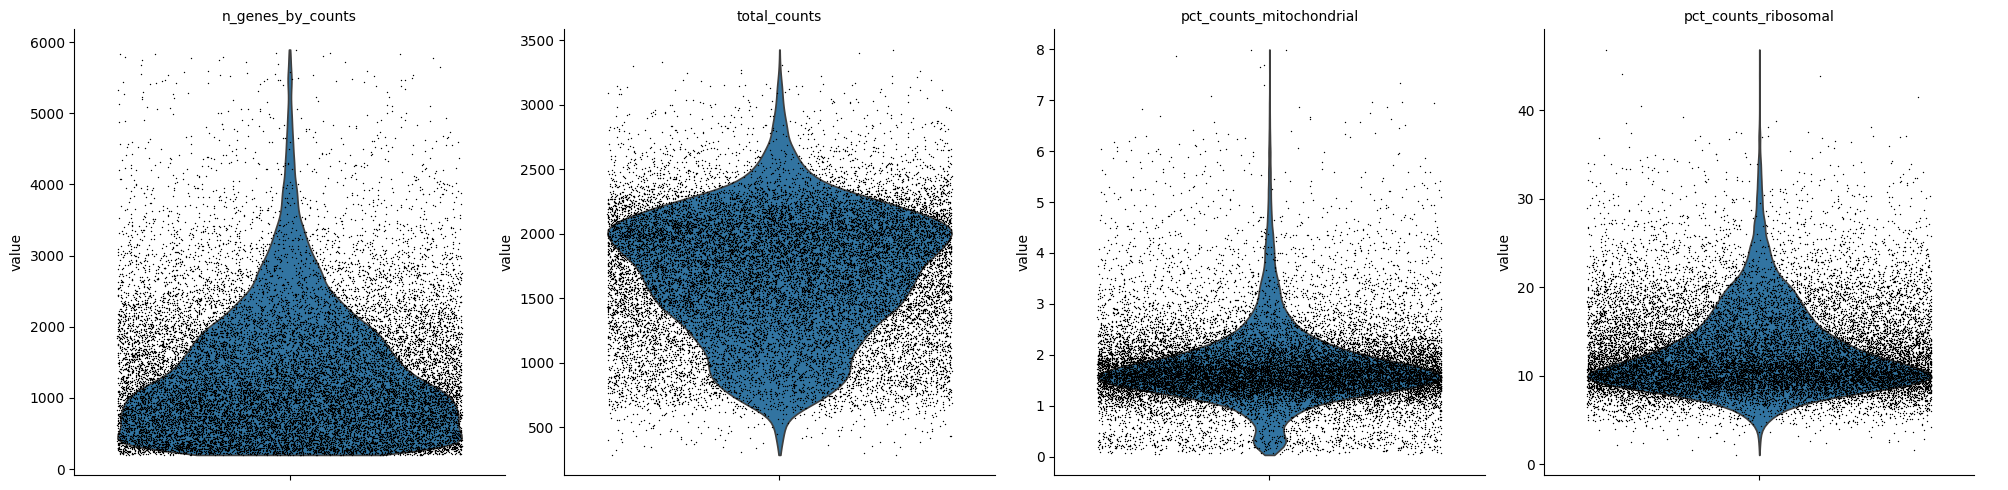

In [9]:
sc.pl.violin(sclcCells, ['n_genes_by_counts', 'total_counts', 'pct_counts_mitochondrial', 'pct_counts_ribosomal'], jitter=0.4, multi_panel=True)

In [10]:
upper_lim = np.quantile(sclcCells.obs.n_genes_by_counts.values, .98)
upper_lim
sclcCells = sclcCells[sclcCells.obs.n_genes_by_counts < upper_lim]
sclcCells = sclcCells[sclcCells.obs.pct_counts_mitochondrial < 20] # less than 20%
sclcCells = sclcCells[sclcCells.obs.pct_counts_ribosomal < 10] # less than 2%

In [11]:
sclcCells

View of AnnData object with n_obs × n_vars = 6114 × 21184
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmoniz

In [12]:
# Normalisation
sc.pp.normalize_total(sclcCells, target_sum=1e4) #normalize every cell to 10,000 UMI
sc.pp.log1p(sclcCells) #change to log counts
sclcCells.X.sum(axis = 1)
sclcCells.raw = sclcCells

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
sc.pp.highly_variable_genes(sclcCells, n_top_genes = 2000)

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [15]:
sclcCells.var

feature_is_filtered original_gene_symbols feature_name  \
ensembl_id                                                                
ENSG00000121410                False                  A1BG         A1BG   
ENSG00000268895                False              A1BG-AS1     A1BG-AS1   
ENSG00000175899                False                   A2M          A2M   
ENSG00000245105                False               A2M-AS1      A2M-AS1   
ENSG00000166535                False                 A2ML1        A2ML1   
...                              ...                   ...          ...   
ENSG00000174903                False                 RAB1B        RAB1B   
ENSG00000159167                False                  STC1         STC1   
ENSG00000136854                False                STXBP1       STXBP1   
ENSG00000135605                False                   TEC          TEC   
ENSG00000109501                False                  WFS1         WFS1   

                feature_reference feature_biotype feature_length  \
ensembl_id                                                         
ENSG00000121410    NCBITaxon:9606            gene           3999   
ENSG00000268895    NCBITaxon:9606            gene           3374   
ENSG00000175899    NCBITaxon:9606            gene           6318   
ENSG00000245105    NCBITaxon:9606            gene           2948   
ENSG00000166535    NCBITaxon:9606            gene           7156   
...                           ...             ...            ...   
ENSG00000174903    NCBITaxon:9606            gene           1950   
ENSG00000159167    NCBITaxon:9606            gene           4134   
ENSG00000136854    NCBITaxon:9606            gene           9358   
ENSG00000135605    NCBITaxon:9606            gene           4004   
ENSG00000109501    NCBITaxon:9606            gene           6369   

                 mitochondrial  ribosomal  n_cells_by_counts  mean_counts  \
ensembl_id                                                                  
ENSG00000121410          False      False               3347     0.156388   
ENSG00000268895          False      False                417     0.017344   
ENSG00000175899          False      False               2695     0.181340   
ENSG00000245105          False      False                149     0.007434   
ENSG00000166535          False      False                 25     0.001475   
...                        ...        ...                ...          ...   
ENSG00000174903          False      False               3156     0.134623   
ENSG00000159167          False      False                129     0.007897   
ENSG00000136854          False      False                376     0.013774   
ENSG00000135605          False      False                271     0.010885   
ENSG00000109501          False      False                473     0.021846   

                 pct_dropout_by_counts  total_counts  n_cells  \
ensembl_id                                                      
ENSG00000121410              83.721609   3215.494629     3347   
ENSG00000268895              97.971889    356.607117      417   
ENSG00000175899              86.892661   3728.530029     2695   
ENSG00000245105              99.275327    152.845627      149   
ENSG00000166535              99.878411     30.327440       25   
...                                ...           ...      ...   
ENSG00000174903              84.650552   2767.977051     3156   
ENSG00000159167              99.372599    162.361725      129   
ENSG00000136854              98.171295    283.200073      376   
ENSG00000135605              98.681971    223.807938      271   
ENSG00000109501              97.699528    449.175537      473   

                 highly_variable     means  dispersions  dispersions_norm  
ensembl_id                                                                 
ENSG00000121410            False  0.512241     1.531479         -1.233271  
ENSG00000268895            False  0.101821     1.920774          0.221848  
ENSG

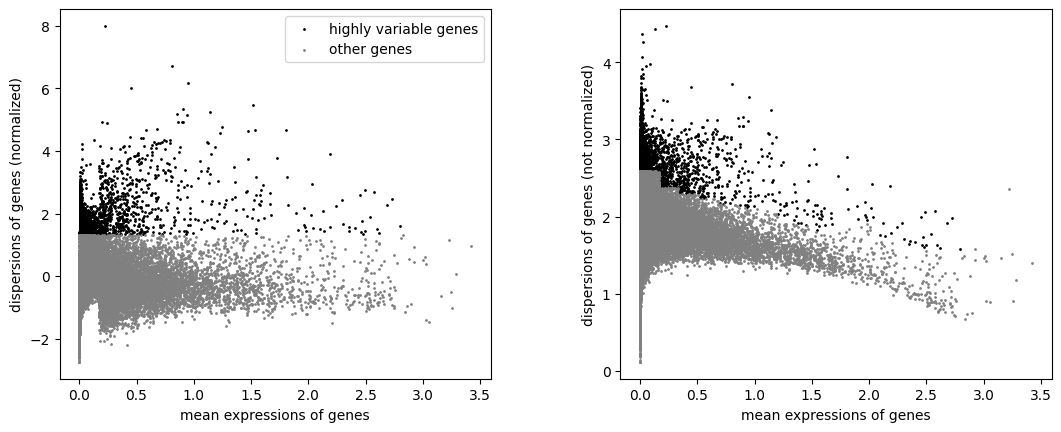

In [16]:
sc.pl.highly_variable_genes(sclcCells)

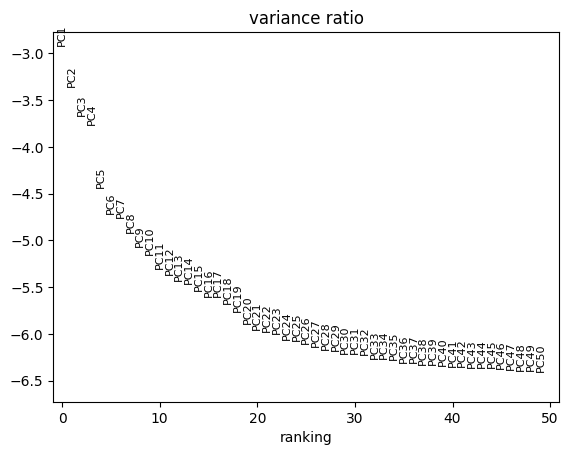

In [17]:
sclcCells = sclcCells[:, sclcCells.var.highly_variable]
sc.pp.regress_out(sclcCells, ['total_counts', 'pct_counts_mitochondrial', 'pct_counts_ribosomal'])
sc.pp.scale(sclcCells, max_value=10)
sc.tl.pca(sclcCells, svd_solver='arpack')
sc.pl.pca_variance_ratio(sclcCells, log=True, n_pcs = 50)

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


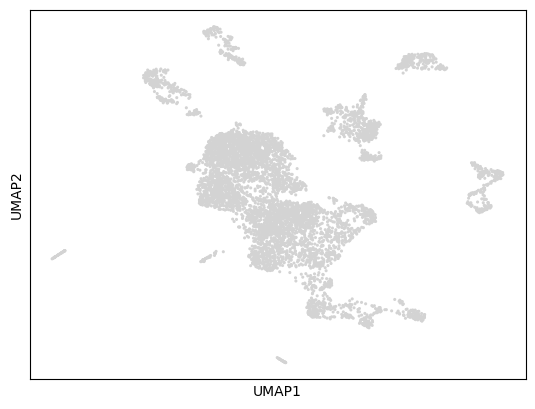

In [23]:
sc.pp.neighbors(sclcCells, n_pcs = 30)
sc.tl.umap(sclcCells)
sc.pl.umap(sclcCells)

In [24]:
sc.tl.leiden(sclcCells, resolution = 0.5)

In [25]:
sclcCells.obs

suspension_type  \
BT1248_GGACAGGATGACCA_lambrechts                 cell   
scrBT1428_GGACGTCAGCTAACAA_lambrechts            cell   
scrBT1428_GTTCTCGCACACAGAG_lambrechts            cell   
BT1248_TAGCATCTGAACTC_lambrechts                 cell   
scrBT1428_CCTCTGAAGACAAAGG_lambrechts            cell   
...                                               ...   
scrBT1428_CGATGTACACTCGACG_lambrechts            cell   
BT1242_GTACGTGACCATGA_lambrechts                 cell   
scrBT1428_AGACGTTTCTATCGCC_lambrechts            cell   
scrBT1428_AACTCCCTCAGATAAG_lambrechts            cell   
BT1247_GCCTCAACAGATCC_lambrechts                 cell   

                                                                                donor_id  \
BT1248_GGACAGGATGACCA_lambrechts       homosapiens_None_2023_None_sikkemalisa_002_d10...   
scrBT1428_GGACGTCAGCTAACAA_lambrechts  homosapiens_None_2023_None_sikkemalisa_002_d10...   
scrBT1428_GTTCTCGCACACAGAG_lambrechts  homosapiens_None_2023_None_sikkemalisa_002_d10...   
BT1248_TAGCATCTGAACTC_lambrechts       homosapiens_None_2023_None_sikkemalisa_002_d10...   
scrBT1428_CCTCTGAAGACAAAGG_lambrechts  homosapiens_None_2023_None_sikkemalisa_002_d10...   
...                                                                                  ...   
scrBT1428_CGATGTACACTCGACG_lambrechts  homosapiens_None_2023_None_sikkemalisa_002_d10...   
BT1242_GTACGTGACCATGA_lambrechts       homosapiens_None_2023_None_sikkemalisa_002_d10...   
scrBT1428_AGACGTTTCTATCGCC_lambrechts  homosapiens_None_2023_None_sikkemalisa_002_d10...   
scrBT1428_AACTCCCTCAGATAAG_lambrechts  homosapiens_None_2023_None_sikkemalisa_002_d10...   
BT1247_GCCTCAACAGATCC_lambrechts       homosapiens_None_2023_None_sikkemalisa_002_d10...   

                                       is_primary_data assay_ontology_term_id  \
BT1248_GGACAGGATGACCA_lambrechts                  True            EFO:0030003   
scrBT1428_GGACGTCAGCTAACAA_lambrechts             True            EFO:0030003   
scrBT1428_GTTCTCGCACACAGAG_lambrechts             True            EFO:0030003   
BT1248_TAGCATCTGAACTC_lambrechts                  True            EFO:0030003   
scrBT1428_CCTCTGAAGACAAAGG_lambrechts             True            EFO:0030003   
...                                                ...                    ...   
scrBT1428_CGATGTACACTCGACG_lambrechts             True            EFO:0030003   
BT1242_GTACGTGACCATGA_lambrechts                  True            EFO:0030003   
scrBT1428_AGACGTTTCTATCGCC_lambrechts             True            EFO:0030003   
scrBT1428_AACTCCCTCAGATAAG_lambrechts             True            EFO:0030003   
BT1247_GCCTCAACAGATCC_lambrechts                  True            EFO:0030003   

                                      cell_type_ontology_term_id  \
BT1248_GGACAGGATGACCA_lambrechts                      CL:0000625   
scrBT1428_GGACGTCAGCTAACAA_lambrechts                 CL:0002144   
scrBT1428_GTTCTCGCACACAGAG_lambrechts                 CL:0000003   
BT1248_TAGCATCTGAACTC_lambrechts                      CL:0000003   
scrBT1428_CCTCTGAAGACAAAGG_lambrechts                 CL:0000583   
...                                                          ...   
scrBT1428_CGATGTACACTCGACG_lambrechts                 CL:0000861   
BT1242_GTACGTGACCATGA_lambrechts                      CL:0000003   
scrBT1428_AGACGTTTCTATCGCC_lambrechts                 CL:0000583   
scrBT1428_AACTCCCTCAGATAAG_lambrechts                 CL:0002144   
BT1247_GCCTCAACAGATCC_lambrechts                      CL:0002144   

                                      development_stage_ontology_term_id  \
BT1248_GGACAGGATGACCA_lambrechts                                 unknown   
scrBT1428_GGACGTCAGCTAACAA_lambrechts                            unknown   
scrBT1428_GTTCTCGCACACAGAG_lambrechts                            unknown   
BT1248_TAGCATCTGAACTC_lambrechts                                 unknown   
scrBT1428_CCTCTGAAGACAAAGG_lambrechts                            unknown   
..

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


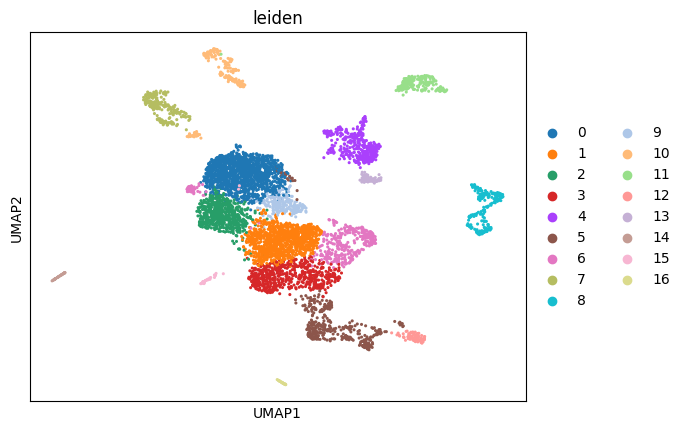

In [26]:
sc.pl.umap(sclcCells, color=['leiden'])

In [27]:
sc.tl.leiden(sclcCells, resolution = 1)
sc.tl.rank_genes_groups(sclcCells, 'leiden')

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:

In [32]:
markers = sc.get.rank_genes_groups_df(sclcCells, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


group            names     scores  logfoldchanges     pvals  pvals_adj
0          0  ENSG00000183019  66.646927        3.003752  0.000000   0.000000
1          0  ENSG00000169442  62.587830        2.200525  0.000000   0.000000
2          0  ENSG00000170323  60.622078        3.328290  0.000000   0.000000
3          0  ENSG00000137880  57.312038        2.309789  0.000000   0.000000
4          0  ENSG00000019169  57.162876        2.144886  0.000000   0.000000
...      ...              ...        ...             ...       ...        ...
445081    21  ENSG00000090520   2.364131        1.620875  0.027288   0.049048
445082    21  ENSG00000211653   2.363094        5.381992  0.027376   0.049173
445083    21  ENSG00000198692   2.359141        2.201022  0.027589   0.049533
445084    21  ENSG00000260916   2.358354        1.696108  0.027629   0.049587
445085    21  ENSG00000147654   2.355658        1.983592  0.027794   0.049808

[32555 rows x 6 columns]

In [101]:
def ensemblIDfGene(adata,gene):
    '''
    ENSEMBL ID from gene
    '''
    obj = adata.var[adata.var.feature_name == gene]
    id = obj.index.tolist()[0]
    return id

def genefEnsemblID(adata,id):
    '''
    Gene from ENSEMBL ID
    '''
    obj = adata.var[adata.var.index == id]
    gene_name = obj.feature_name.tolist()[0]
    return gene_name

ENSG00000175899
A2M


In [91]:
scvi.model.SCVI.setup_anndata(sclc)

'A2M'

In [149]:
sclcCells.obs.sample.un

AttributeError: 'function' object has no attribute 'unique'

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


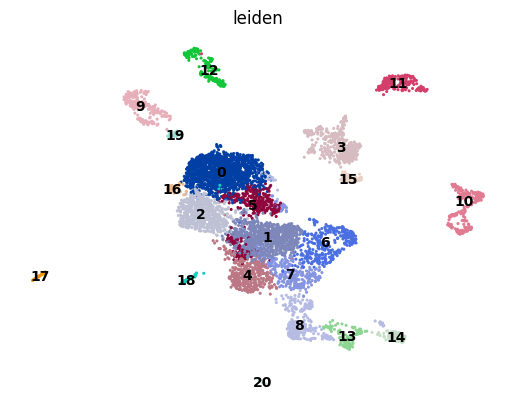

In [135]:
sc.pl.umap(sclcCells, color = ['leiden'], frameon = False, legend_loc = "on data")

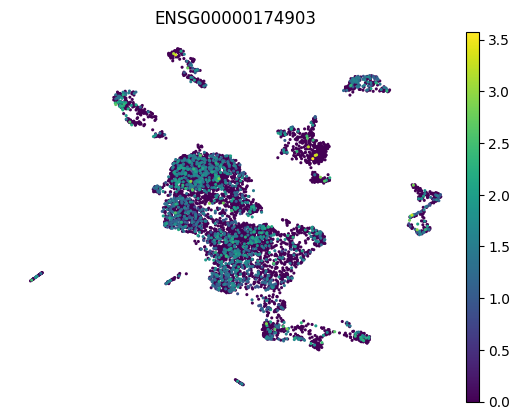

In [162]:
sc.pl.umap(sclcCells, color = ['ENSG00000174903'], frameon = False, vmax = 5)

In [159]:
ensemblIDfGene(sclcCells, 'ENSG00000187634')

IndexError: list index out of range

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


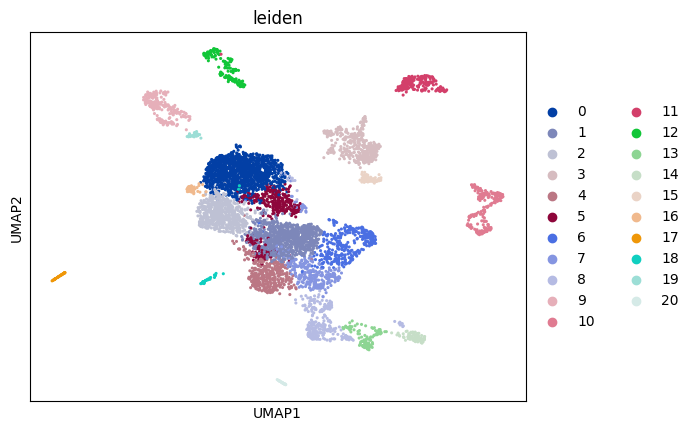

In [106]:
sc.tl.leiden(
    sclcCells,
    resolution=0.9,
    random_state=0,
    n_iterations=2,
    directed=False,
)

sc.pl.umap(sclcCells, color=["leiden"])

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:

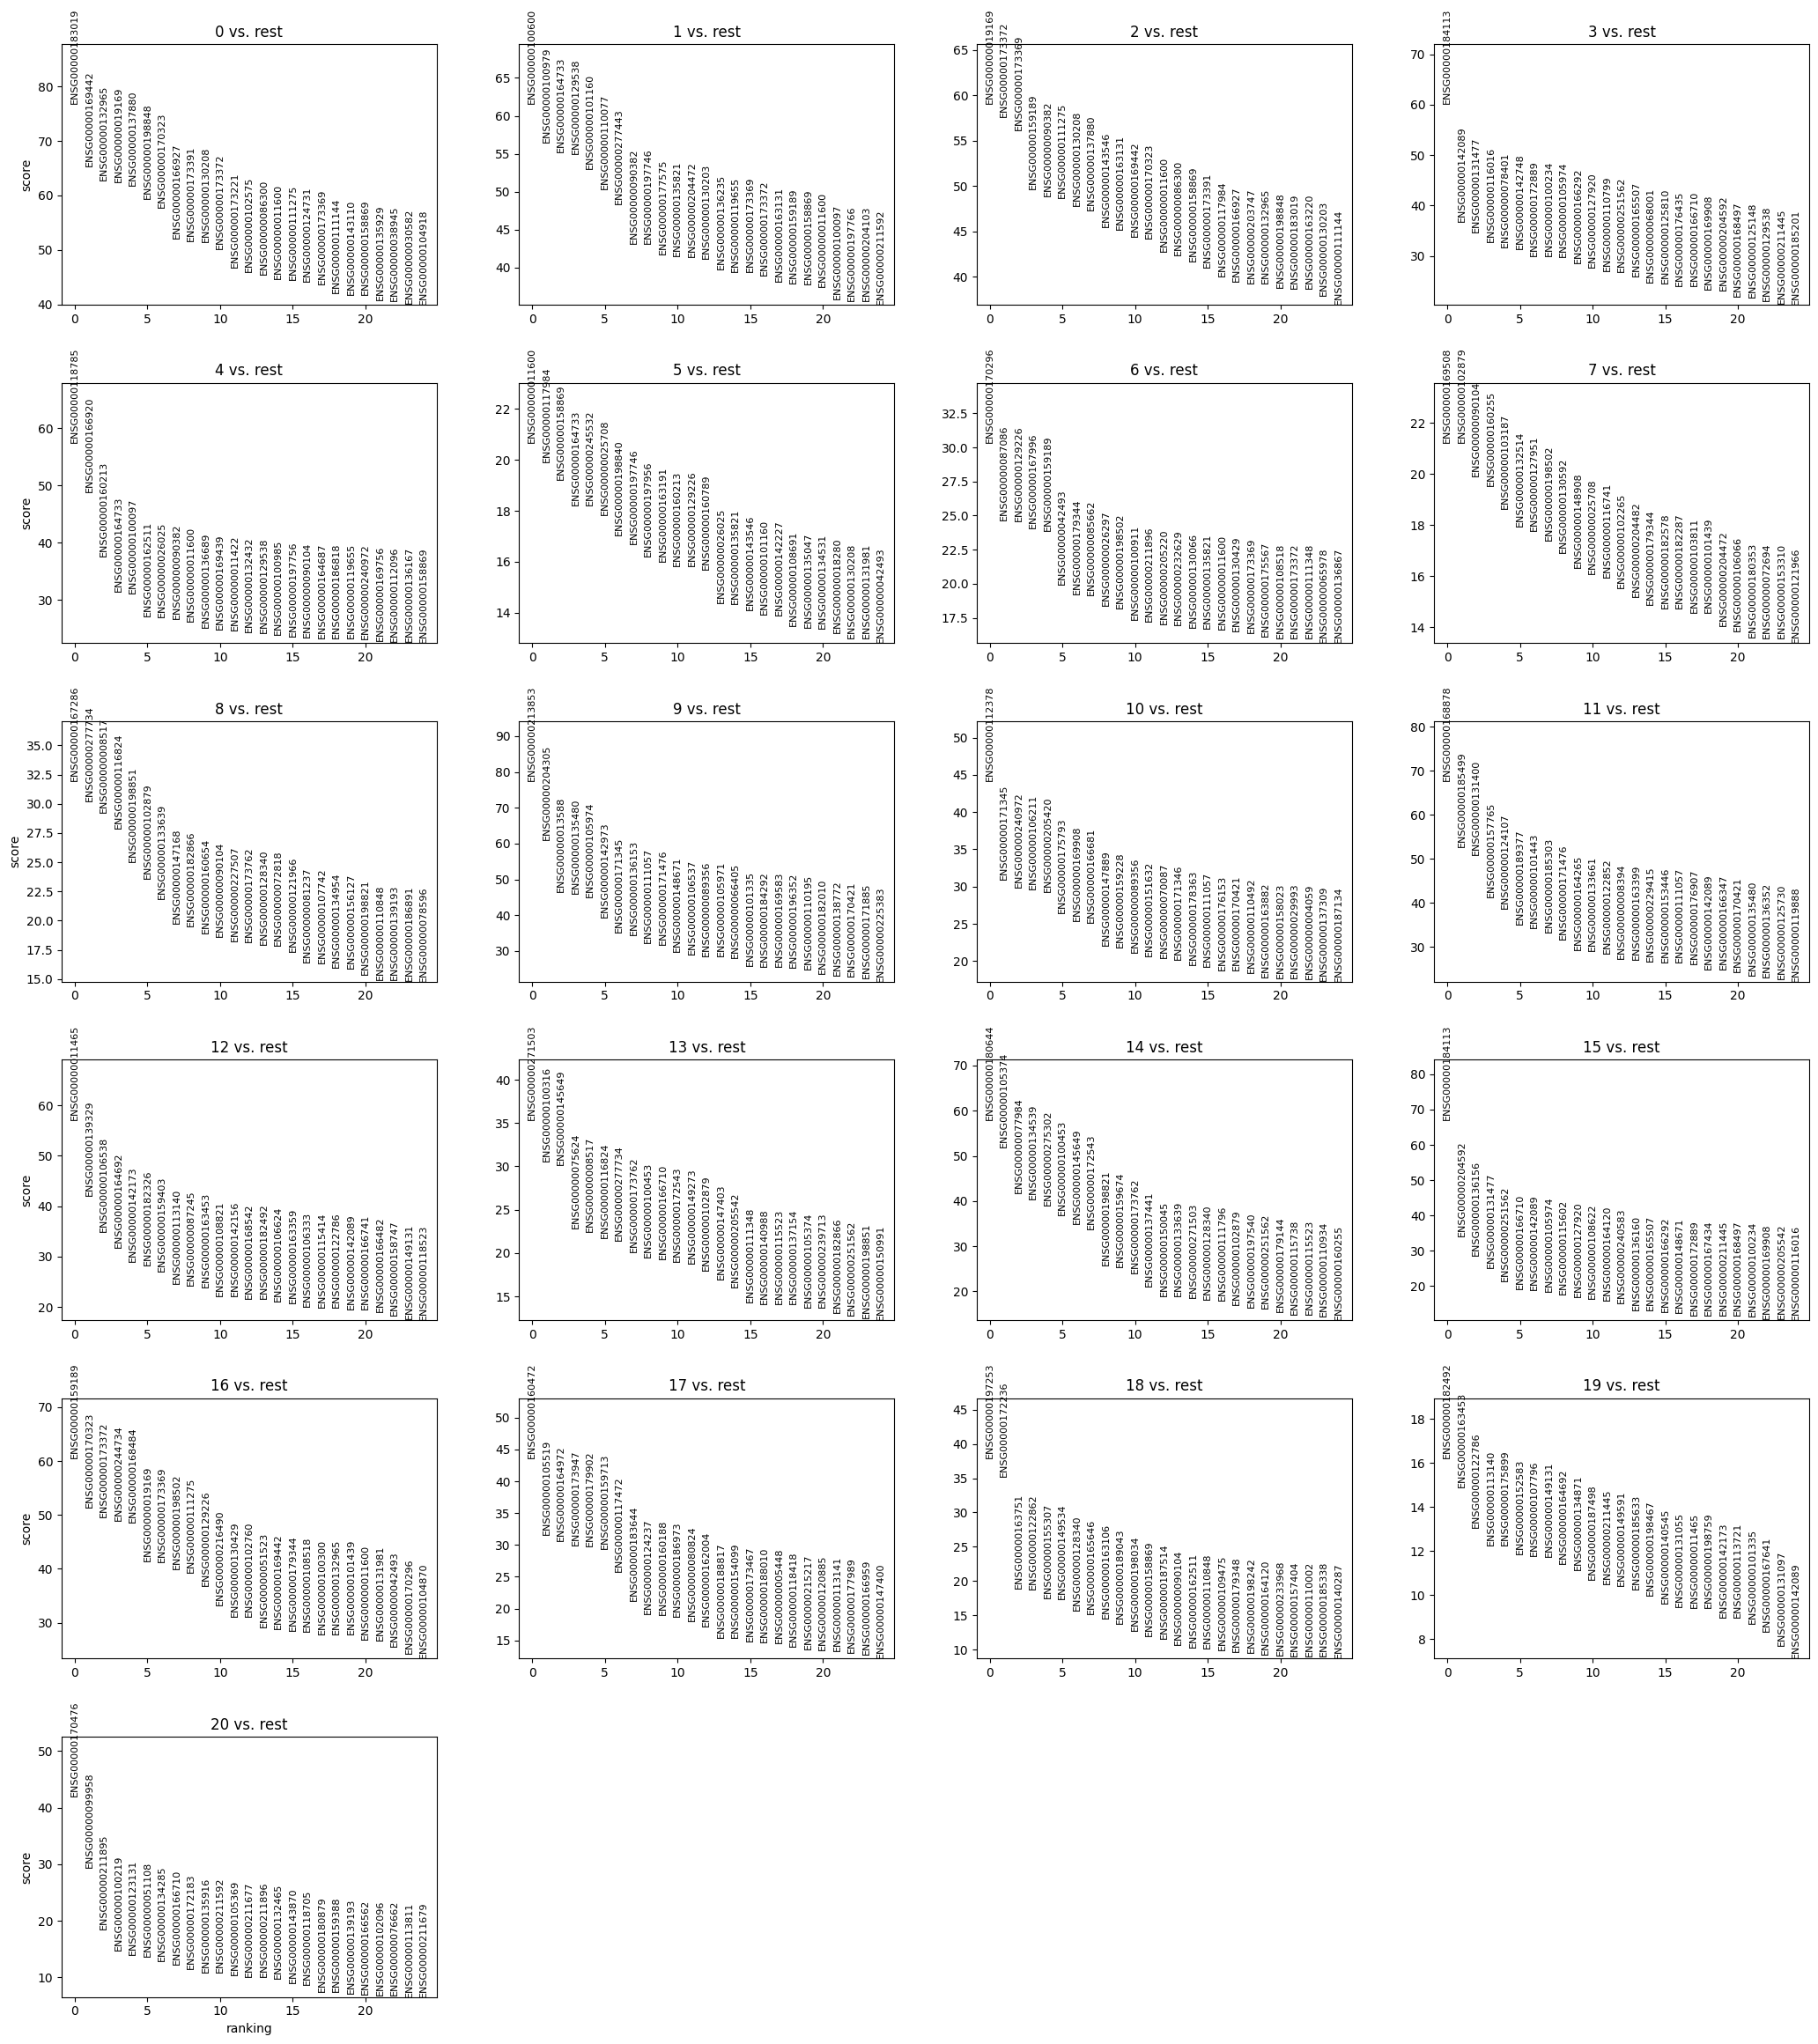

In [107]:
sc.tl.rank_genes_groups(sclcCells, "leiden", method="t-test")
sc.pl.rank_genes_groups(sclcCells, n_genes=25, sharey=False)

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

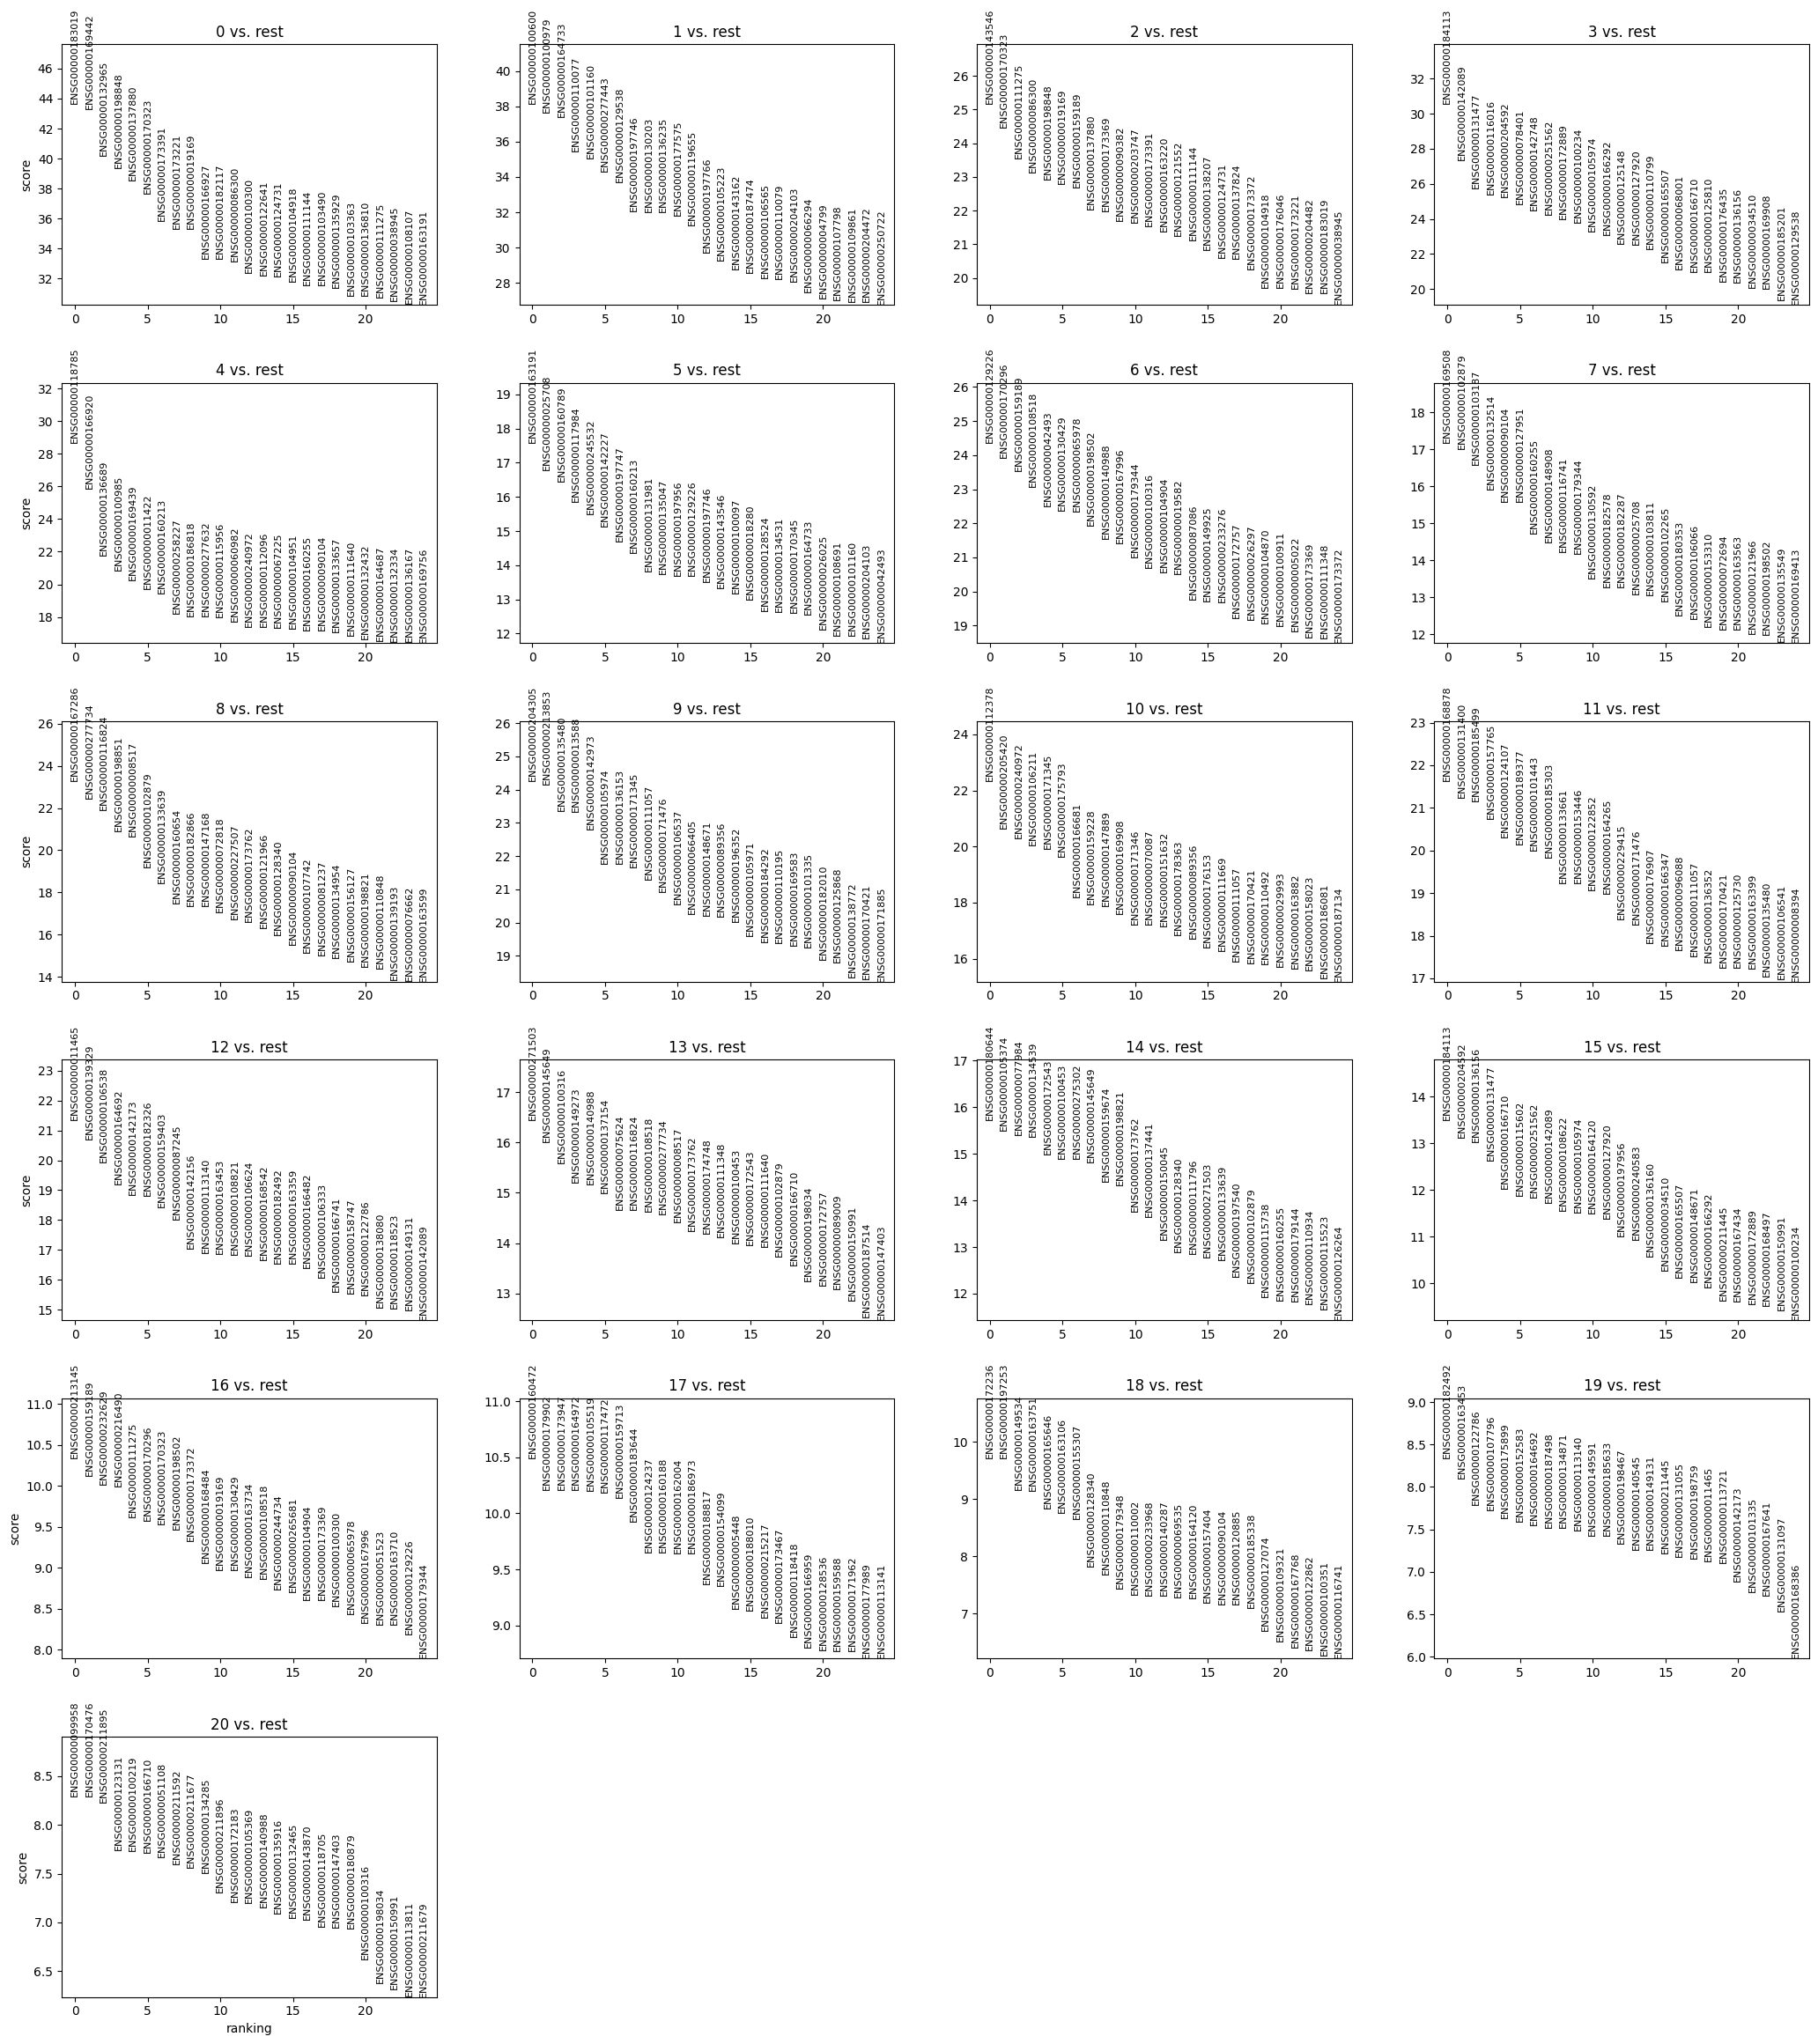

In [108]:
sc.tl.rank_genes_groups(sclcCells, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(sclcCells, n_genes=25, sharey=False)

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


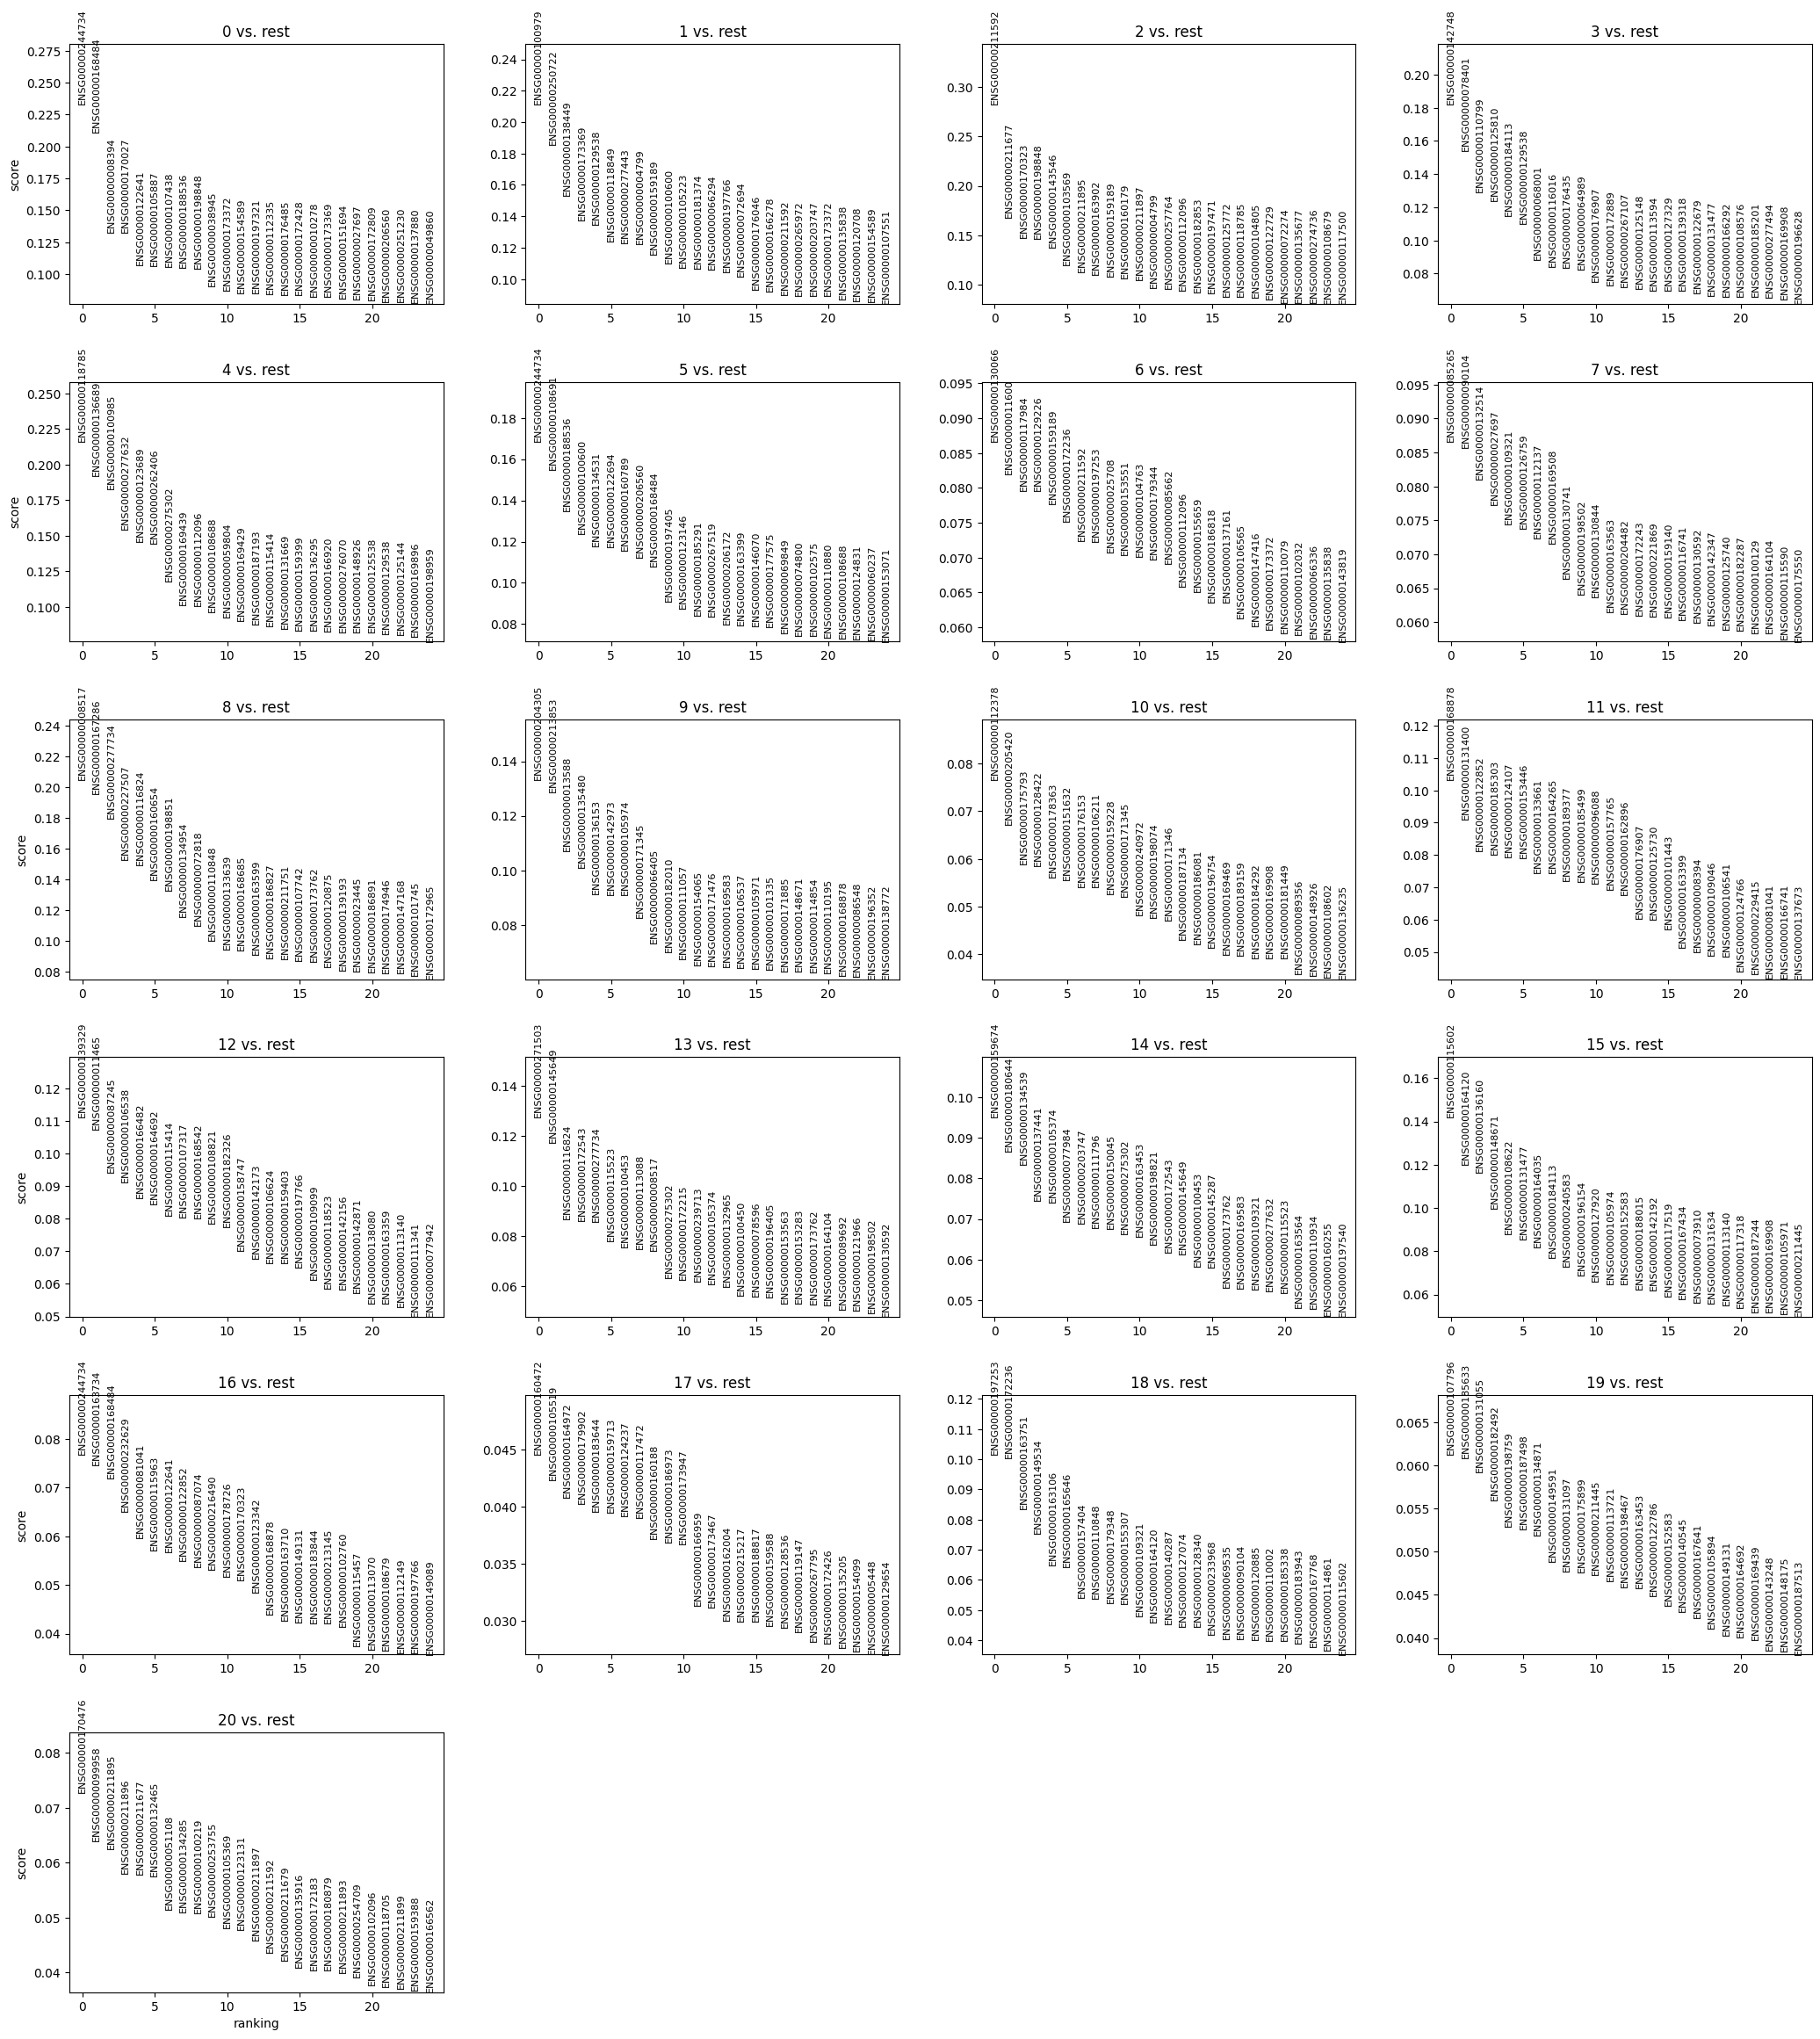

In [109]:
sc.tl.rank_genes_groups(sclcCells, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(sclcCells, n_genes=25, sharey=False)

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


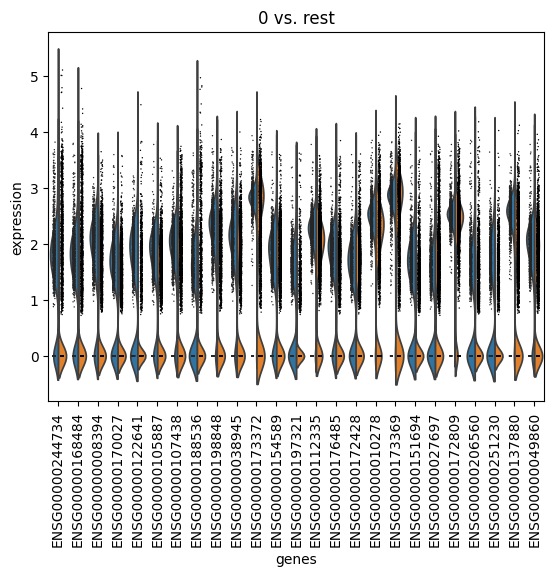

In [136]:
sc.pl.rank_genes_groups_violin(sclcCells, groups="0", n_genes=25)

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


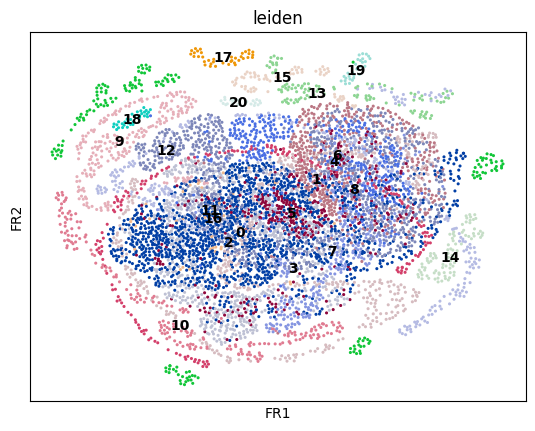

In [122]:
sc.tl.draw_graph(sclcCells)
sc.pl.draw_graph(sclcCells, color=['leiden'], legend_loc="on data")

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


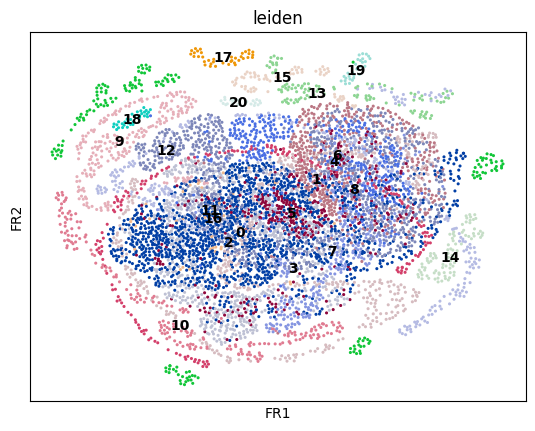

In [119]:
sc.tl.diffmap(sclcCells)
sc.pp.neighbors(sclcCells, n_neighbors=10, use_rep="X_diffmap")
sc.tl.draw_graph(sclcCells)
sc.pl.draw_graph(sclcCells, color="leiden", legend_loc="on data")
